In [1]:
import pandas as pd
import os
import glob


In [2]:
# Following script combines the annotation data with the time series data
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\Daytime_Annotation'
dict_path = r'Y:\DeepSleepPaperData\basty-daytime\tmp_results\predictions\ProboscisPumping\bouts_dict.pkl'

def process_row(row, dictionary, N):
    df_dict = dictionary[row['name']]
    df_dict_filtered = df_dict.drop(['start_index', 'stop_index', 'region'], axis=1)

    trial_id = int(row['trial_id'])
    peak_index = row['peak_index']

    # New dictionary to store sliced data with column names
    sliced_data_dict = {}

    for col in df_dict_filtered.columns:
        if peak_index-N >= 0 and peak_index+N <= len(df_dict_filtered.loc[trial_id, col]):
            start = max(0, peak_index - N)
            end = min(len(df_dict_filtered.loc[trial_id, col]), peak_index + N)
            sliced_data_dict[col] = df_dict_filtered.loc[trial_id, col][start:end]

    return sliced_data_dict


In [3]:

pkl_files = glob.glob(os.path.join(path, '*.pkl'))
ts_dict = pd.read_pickle(dict_path)

df_list = []  # A list to store each DataFrame


for file in pkl_files:
    data = pd.read_pickle(file)
    df = pd.DataFrame(data)
    df['name'] = os.path.splitext(os.path.basename(file))[0]
    df_list.append(df)  # Append the DataFrame to the list

# Concatenate all the DataFrames in the list into a single DataFrame
annotations = pd.concat(df_list, ignore_index=True)

# Rename the columns to make it more intuitive
annotations.rename(columns = {'index':'peak_index','column':'trial_id'},inplace=True)

In [11]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel\Daytime_Annotation\output'
annotations.to_pickle(os.path.join(output_path,'true_annotations.pkl'))

In [5]:
import pandas as pd
import os

# Load annotations and experimental info: 
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\Daytime_Annotation'
annotations = pd.read_pickle(os.path.join(path,'output','true_annotations.pkl'))
expt_info_df_path = r'Y:\DeepSleepPaperData\basty-daytime\expt_info_df.pkl'
expt_info_df = pd.read_pickle(expt_info_df_path)

# Fetch all .mp4 files from the directory
directory = r'Y:\Temp'
file_names = [f for f in os.listdir(directory) if f.endswith('.mp4')]

# Process each filename
data = []

for file in file_names:
    parts = file.split("_")

    index_position = parts.index('index')
    name = "_".join(parts[:index_position])
    trial_id = int(parts[index_position + 1])
    start = int(parts[parts.index('start') + 1])

    data.append([name, trial_id, start])

# Construct the DataFrame
df = pd.DataFrame(data, columns=["name", "trial_id", "start"])

annotations['trial_id'] = annotations['trial_id'].astype('int64')
df['trial_id'] = df['trial_id'].astype('int64')
merged_df = annotations.merge(df[['name', 'trial_id', 'start']], on=['name', 'trial_id'], how='left')

merged_df['pump_pos'] = merged_df['peak_index'] + merged_df['start']

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Helper function to plot given a subset of df
def plot_data(subset_df, color, sd, sex):
    sns.set(style="ticks")
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))

    color='#FF7F0E'
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        for _, row in sub_subset_df.iterrows():
            pump_pos = row['pump_pos']
            ax.barh(idx, 60, left=pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'Daytime_Pump_Positions_{title}.pdf')
    plt.show()


# Function to plot data for SD = True
def plot_sd_true():
    df_sd_true = df[df['name'].map(name_to_sd)]
    plot_data(df_sd_true, '#377eb8', sd=True)


# Function to plot data for SD = False
def plot_sd_false():
    df_sd_false = df[~df['name'].map(name_to_sd)]
    plot_data(df_sd_false, '#d62728', sd=False)
    
def plot_sub_data(df, expt_info_df, sd, sex,plot_it):

    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_data(sub_df, '#d62728', sd=sd,sex=sex)
        
    plt.show()
    
    return sub_df,sd,sex
    
def generate_tick_data(FPS=30, sd=False):

    if not sd:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 12 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        # Generate labels from ZT0 to ZT12
        ZT_ticklabels = ["ZT" + str(tick) for tick in range(0, 13)]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels


In [27]:
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

df = merged_df

df_sd_false = df[~df['name'].map(name_to_sd)]

<Figure size 640x480 with 0 Axes>

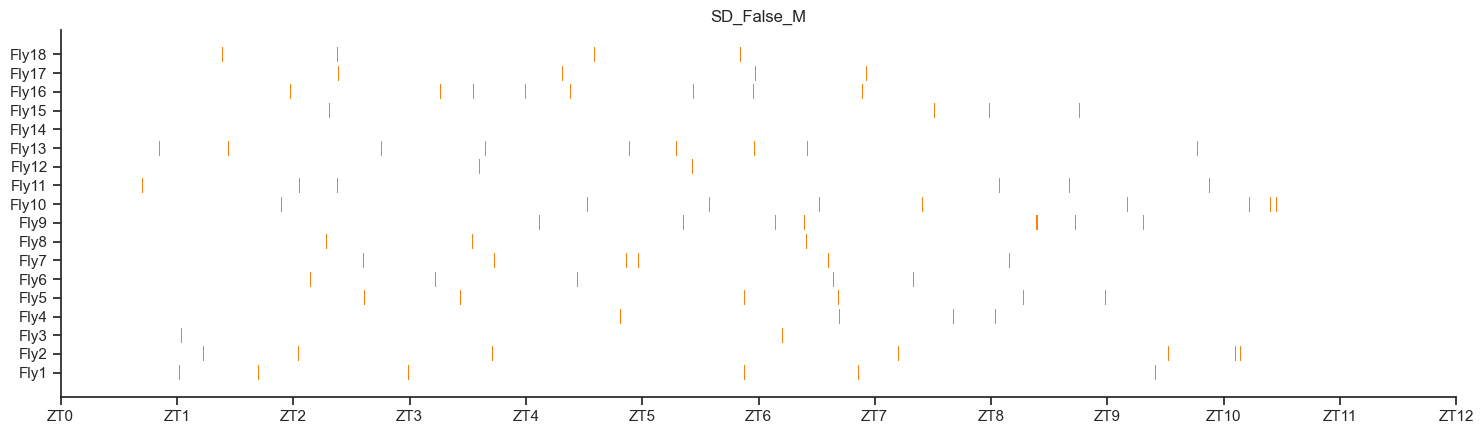

<Figure size 640x480 with 0 Axes>

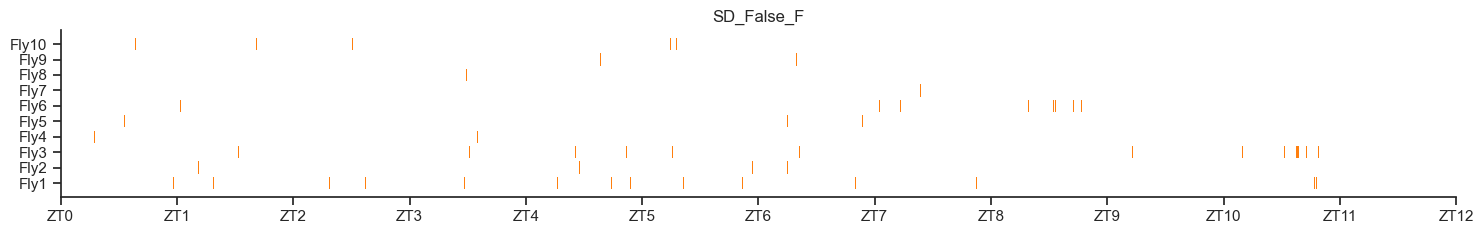

(      peak_index       value  trial_id               name   start  pump_pos
 317          553  929.602316         1  Fly-Aug-24-2024_B   15669     16222
 318          620  932.093574         1  Fly-Aug-24-2024_B   15669     16289
 319          690  928.802695         1  Fly-Aug-24-2024_B   15669     16359
 320          758  928.486619         1  Fly-Aug-24-2024_B   15669     16427
 321          860  932.732451         1  Fly-Aug-24-2024_B   15669     16529
 ...          ...         ...       ...                ...     ...       ...
 2178         935  625.433523        54  Fly-Sep-07-2024_A  795159    796094
 2179        1008  625.394778        54  Fly-Sep-07-2024_A  795159    796167
 2180        1080  626.390521        54  Fly-Sep-07-2024_A  795159    796239
 2181        1142  627.227043        54  Fly-Sep-07-2024_A  795159    796301
 2182        1225  625.769194        54  Fly-Sep-07-2024_A  795159    796384
 
 [809 rows x 6 columns],
 False,
 'F')

In [28]:
plot_sub_data(df,expt_info_df,sd=False,sex='M',plot_it=True)
plot_sub_data(df,expt_info_df,sd=False,sex='F',plot_it=True)

In [29]:
import pandas as pd
sns.set_style('ticks')
def plot_bin_data(sub_df,sd,sex,plot_it=False):
        # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
        
    plt.clf()
    
    plot_Df = sub_df
    # Convert pump_pos to minutes
    plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)
    
    # Define bin edges for 60-minute intervals
    max_minutes = plot_Df['pump_pos_minutes'].max()
    bins = list(range(0, int(max_minutes) + 61, 60))
    
    # For each unique 'name', bin the data and count values in each bin
    binned_data = {}
    for name, group in plot_Df.groupby('name'):
        binned_data[name] = pd.cut(group['pump_pos_minutes'], bins=bins).value_counts()
    
    # Convert the binned_data dictionary to a DataFrame
    binned_df = pd.DataFrame(binned_data).T
    binned_df = binned_df.fillna(0).astype(int)  # Replace NaN values with zeros and convert to integer type
    
    # Calculate the average for each bin across all "names"
    melted_df = binned_df.melt(var_name='Time Bin', value_name='Average Count')
    
    import seaborn as sns

    if plot_it==True:
        # Create the boxplot using seaborn
        plt.figure(figsize=(12, 6))
        sns.barplot(data=melted_df, x='Time Bin', y='Average Count', color='skyblue', errorbar='se')
        # Adjusted box width and color
        
        # Calculate the median values for each time bin and plot them
        means = melted_df.groupby('Time Bin')['Average Count'].mean()
        plt.plot(range(len(means)), means, color='black', linestyle='-', marker='o')
        
        # Set the x-tick labels to your ZT values
        if ~sd:
            ZT_labels = [f"ZT{((i) % 24)}" for i in range(len(means))]
            plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
        else:
            ZT_labels = [f"ZT{((i))}" for i in range(len(means))]
            plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
                
    
        # Set y-label
        plt.ylabel("Pump per Hour")
    
        
        title = f"Avg_Binned_SD_{sd}_sex{sex}"
        plt.title(title)
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{title}_barplot_daytime.pdf')
        plt.show()
        
    else: 
        return binned_df

C:\Users\Grover\AppData\Local\Temp\ipykernel_22076\4269396593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)


<Figure size 640x480 with 0 Axes>

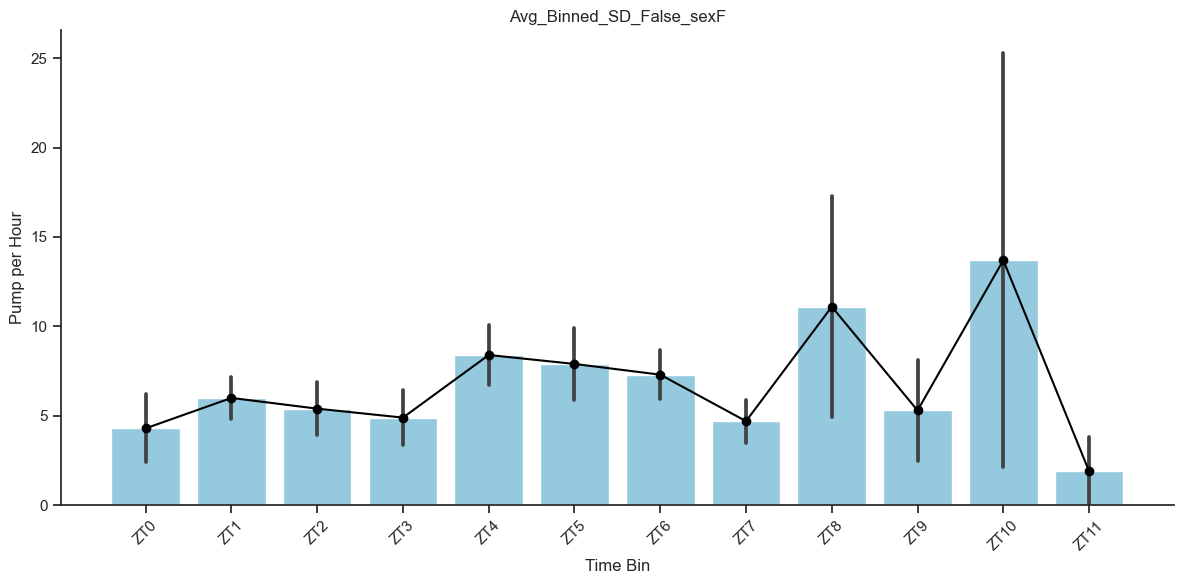

In [47]:
plot_bin_data(df,sd =False,sex='F',plot_it=True)

In [32]:
xpt_info_df

,ExptNames,Path,SD,Age,Sex,Experimenter
0,Fly-Aug-22-2024_A,Y:\DeepSleepPaperData\Daytime\Fly-Aug-22-2024_A,False,5.0,M,MK
1,Fly-Aug-22-2024_B,Y:\DeepSleepPaperData\Daytime\Fly-Aug-22-2024_B,False,5.0,M,MK
2,Fly-Aug-23-2024_A,Y:\DeepSleepPaperData\Daytime\Fly-Aug-23-2024_A,False,5.0,M,MK
3,Fly-Aug-23-2024_B,Y:\DeepSleepPaperData\Daytime\Fly-Aug-23-2024_B,False,5.0,M,MK
4,Fly-Aug-24-2024_A,Y:\DeepSleepPaperData\Daytime\Fly-Aug-24-2024_A,False,5.0,F,MK
5,Fly-Aug-24-2024_B,Y:\DeepSleepPaperData\Daytime\Fly-Aug-24-2024_B,False,5.0,F,MK
6,Fly-Aug-25-2024_A,Y:\DeepSleepPaperData\Daytime\Fly-Aug-25-2024_A,False,5.0,M,MK
7,Fly-Aug-25-2024_B,Y:\DeepSleepPaperData\Daytime\Fly-Aug-25-2024_B,False,5.0,M,MK
8,Fly-Aug-26-2024_A,Y:\DeepSleepPaperData\Daytime\Fly-Aug-26-2024_A,False,5.0,M,MK
9,Fly-Aug-26-2024_B,Y:\DeepSleepPaperData\Daytime\Fly-Aug-26-2024_B,False,5.0,F,MK


In [6]:
# Calculate Bouts
def calculate_bouts(target_df, target_threshold):
    # Re-initialize the 'bouts' column with default value 0
    target_df['bouts'] = 0
    
    # Loop through each unique 'name' to identify bouts based on 'pump_pos'
    for name in target_df['name'].unique():
        # Filter the DataFrame for the current 'name'
        subset_df = target_df[target_df['name'] == name].sort_values(by='pump_pos')
        
        # Calculate the differences between consecutive 'pump_pos'
        pump_diffs = subset_df['pump_pos'].diff().fillna(0)
        
        # Initialize a variable to keep track of the current bout number
        current_bout = 0
        
        # Initialize a variable to keep track of the last pump position in the current bout
        last_pump_in_bout = -1
        
        # Loop through the DataFrame to identify bouts
        for idx, pump_diff in pump_diffs.items():
            if pump_diff > target_threshold:
                # If the difference between the current and last pump position is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            elif last_pump_in_bout != -1 and (target_df.loc[idx, 'pump_pos'] - last_pump_in_bout) > target_threshold:
                # If the difference between the current pump position and the last pump position in the current bout is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            else:
                # Otherwise, the current pump position is part of the current bout
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            
            # Label the current bout number in the 'bouts' column
            target_df.loc[idx, 'bouts'] = current_bout
            
    return target_df



In [10]:
# Update the threshold for identifying bouts to 210
threshold = 330
bout_df = merged_df.copy()

In [11]:
df = calculate_bouts(bout_df,threshold)
sorted_df = df.sort_values(by=['name', 'pump_pos'])

In [13]:
slim_df = sorted_df.copy()

# Remove value trial_id,peak_index, and pump_pos_minutes from the dataset
slim_df = slim_df.drop(['value','trial_id','peak_index'],axis=1)

In [14]:
# Group by 'name', 'pump_pos', and 'bouts', then aggregate with min for 'start' and count for 'index'
fin_df = slim_df.groupby(['name', 'bouts']).agg(first_instance=('pump_pos', 'min'), count=('bouts', 'count')).reset_index()

In [17]:
fin_df

,name,bouts,first_instance,count
0,Fly-Aug-22-2024_A,0,110350,5
1,Fly-Aug-22-2024_A,1,148081,2
2,Fly-Aug-22-2024_A,2,183707,3
3,Fly-Aug-22-2024_A,3,248997,1
4,Fly-Aug-22-2024_A,4,322844,2
...,...,...,...,...
540,Fly-Sep-07-2024_A,11,571612,6
541,Fly-Sep-07-2024_A,12,650054,2
542,Fly-Sep-07-2024_A,13,721773,4
543,Fly-Sep-07-2024_A,14,759849,3


In [18]:
# Save fin_df to a csv file
fin_df.to_csv('bout_data_daytime.csv')